In [1]:
#from selenium import webdriver
import requests
from bs4 import BeautifulSoup, Tag
import pandas as pd
import time
import random
import torch
import zipfile
import os
import csv
import email
import re
from IPython.display import clear_output
!rm -rf sample_data

In [2]:
def load_html_file(path):
    with open(path, 'r') as f:
        contents = f.read()
        page_soup = BeautifulSoup(contents, 'html.parser')
    return page_soup

def load_mhtml_file(path):
    with open(path) as fp:
        message = email.message_from_file(fp)
        for part in message.walk():
            if (part.get_content_type() == "text/html"):
                page_soup = BeautifulSoup(part.get_payload(decode=False), 'html.parser')
                break  # only extract first html part
    return page_soup

def load_page(URL, random_delay=True, min_delay=0.6, max_delay=2.5):
    if random_delay:
        time.sleep(random.uniform(min_delay, max_delay))
    page = requests.get(URL)
    page_soup = BeautifulSoup(page.content, 'html.parser')
    return page_soup

In [3]:
directory = 'reviews'
with zipfile.ZipFile("CommentPages.zip", 'r') as zip_ref:
    zip_ref.extractall(directory)

In [4]:
GPU_url_map = {}
GPU_info = []
path_prefix = directory +'/'
with open('GPU_info.csv', newline='', encoding='utf-8-sig') as csvfile:
    reader = csv.reader(csvfile, delimiter=';', quotechar='|')
    for row in reader:
        GPU_info.append(row)
        gpu = row[0]
        fn = row[1] + '.html'
        shared_review = row[2]
        GPU_url_map[gpu] = [fn]
        # search for further comment pages
        for i in range(2,6):
            new_fn = fn.replace('- 1', '- '+str(i))
            if not os.path.exists(path_prefix + new_fn):
                break
            GPU_url_map[gpu].append(new_fn)

for gpu in list(GPU_url_map.keys())[:5]:
    print(f'{gpu}:     {GPU_url_map[gpu]}')

RTX 4090:     ['RTX 4090 - 1.html', 'RTX 4090 - 2.html']
RTX 4080:     ['RTX 4080 - 1.html', 'RTX 4080 - 2.html']
RTX 3090 Ti:     ['RTX 3090 Ti - 1.html']
RTX 3090:     ['RTX 3090 - 1.html', 'RTX 3090 - 2.html']
RTX 3080 Ti:     ['RTX 3080 Ti - 1.html']


## Extract review text

In [5]:
def clean_element(element):
    text = element.text.strip()
    if element.name == 'h2' and not text[-1] == '.':
        # Add period to subtitle (for later processing)
        text += '.'
    return text

full_review = False # If true: extract whole review
GPU_reviews = {}
for gpu in GPU_url_map.keys():
    fn = path_prefix + GPU_url_map[gpu][0]
    soup = load_html_file(fn)
    chapter = soup.find('h2', {'class': 'chapter'}).text
    if 'Conclusie' in chapter or full_review:
        article = soup.find('div', {'class': 'article fullWidth'})
        elements = article.find_all(['h2', 'p'], recursive=False)
        segments = []
        if not elements is None:
            segments = list(map(clean_element, elements))
        GPU_reviews[gpu] = ' '.join(segments)

## Extract comments

In [6]:
def clean_comment(s):
    # Remove quotes, URLs, metadata and whitespace and other elements
    # that do not relate to sentiment
    for blockquote in s.findAll('blockquote'):
        blockquote.replace_with(' ')
    for edit in s.findAll('p', {'class': 'edit'}):
        edit.extract()
    s_str = s.text
    s_str = re.sub(r'http\S+', ' ', s_str)
    s_str = ' '.join(s_str.strip().split())
    return s_str

In [7]:
GPU_comments = {}
for gpu in GPU_url_map.keys():
    GPU_comments[gpu] = [] # initialise comments list
    for fn in GPU_url_map[gpu]:
        fn = path_prefix + fn
        soup = load_html_file(fn)
        #chapter = soup.find('h2', {'class': 'chapter'}).text
        comments_soup = soup.find_all('div', {'class': 'reactieContent'})
        #print(fn, len(comments_soup))
        comments = list(map(clean_comment, comments_soup))
        GPU_comments[gpu] += comments

In [8]:
print(len(GPU_comments['RTX 4090']))

307


## Load RobBERT-v2 model

In [9]:
!pip install transformers
clear_output()

In [10]:
from transformers import RobertaTokenizer, AutoTokenizer
from transformers import RobertaForSequenceClassification
from transformers import pipeline

cuda = torch.device('cuda:0')

#tokenizer_robbert = RobertaTokenizer.from_pretrained("DTAI-KULeuven/robbert-v2-dutch-sentiment")
tokenizer_bert = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", device=cuda)

#robbert_pipe = pipeline("sentiment-analysis", model="DTAI-KULeuven/robbert-v2-dutch-sentiment")
bert_pipe = pipeline("sentiment-analysis", tokenizer=('nlptown/bert-base-multilingual-uncased-sentiment',{'model_max_length':512}),
                     model="nlptown/bert-base-multilingual-uncased-sentiment", device=cuda)
clear_output()

In [11]:
def nearest_period_index(ids : list, split_id=119, side='tail') -> int:
    length = len(ids)
    for i in range(length):
        if side == 'tail':
            i = length-1 - i
        if ids[i] == split_id:
            return i

def limit_input(input : str, tokenizer, input_limit=512) -> str:
    # If input-length > 512; keep head and tail of the input such that it fits in the input-size limit of BERT
    # Also moves truncation position to nearest period (to keep whole sentences).
    encoding_bert = tokenizer(input)
    if len(encoding_bert['input_ids']) <= 512:
        return input
    period_id = 119
    maxlen = input_limit // 2  # max length of head & tail of the input

    head_ids = encoding_bert['input_ids'][:maxlen+1]
    period_i = nearest_period_index(head_ids, split_id=119, side='tail')
    head_ids = head_ids[:period_i +1]  # +1 to include tailing period
    head_tokens = tokenizer.convert_ids_to_tokens(head_ids)[1:] # 1: to remove [CLS]
    trunc_head = tokenizer_bert.convert_tokens_to_string(head_tokens)
    
    # truncated tokens to period are added to the last part
    extra_tokens = maxlen -period_i -1
    maxlen +=  extra_tokens

    tail_ids = encoding_bert['input_ids'][-maxlen-1:]
    period_i = nearest_period_index(tail_ids, split_id=119, side='head')
    tail_ids = tail_ids[period_i +1:]  # +1 to exclude leading period
    tail_tokens = tokenizer.convert_ids_to_tokens(tail_ids)[:-1] # :1 to remove [SEP]
    trunc_tail = tokenizer_bert.convert_tokens_to_string(tail_tokens)
    return trunc_head +' '+ trunc_tail

def sentiment(string, pipeline=bert_pipe, showresults=True): # REMOVED: pipeline1=robbert_pipe
    sentiment = pipeline(string)
    rating_strings = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
    rating = rating_strings.index(sentiment[0]['label']) + 1
    confidence = sentiment[0]['score'] # confidence?
    if showresults:
        print(f"{rating}/5 star {'%.3f' % confidence}")
    return rating, confidence

### Extract scores for comments of every GPU model

In [12]:
GPU_results = {}  # {gpu : (rev_stars, rev_conf, avg_cmt_stars, [cmt_results]) }

limit_comments = 9999
limit_gpus = 999

gpu_nr = 0
for gpu in GPU_url_map.keys():
    gpu_nr += 1
    if gpu_nr > limit_gpus: break
    print(f"Analyse {gpu} review")
    review = limit_input(GPU_reviews[gpu], tokenizer_bert)
    rev_stars, rev_conf = sentiment(review, showresults=True)
    cmt_scores = []
    cmt_nr = 0
    for c in GPU_comments[gpu]:
        cmt_nr += 1
        if cmt_nr > limit_comments: break
        c = limit_input(c, tokenizer_bert)
        cmt_stars, cmt_conf = sentiment(c, showresults=False)
        cmt_scores.append( (c, cmt_stars, cmt_conf) )
    GPU_results[gpu] = (rev_stars, rev_conf, cmt_scores)

Token indices sequence length is longer than the specified maximum sequence length for this model (772 > 512). Running this sequence through the model will result in indexing errors


Analyse RTX 4090 review
2/5 star 0.381


/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Analyse RTX 4080 review
1/5 star 0.446
Analyse RTX 3090 Ti review
2/5 star 0.475
Analyse RTX 3090 review
2/5 star 0.326
Analyse RTX 3080 Ti review
2/5 star 0.430
Analyse RTX 3080 review
2/5 star 0.307
Analyse RTX 3070 Ti review
2/5 star 0.356
Analyse RTX 3070 review
3/5 star 0.329
Analyse RTX 3060 Ti review
4/5 star 0.341
Analyse RTX 3060 review
2/5 star 0.514
Analyse RTX 3050 review
2/5 star 0.367
Analyse RTX 2080 Ti review
2/5 star 0.501
Analyse RTX 2080 review
2/5 star 0.501
Analyse RTX 2070 review
3/5 star 0.444
Analyse RTX 2060 review
3/5 star 0.411
Analyse GTX 1660 Ti review
2/5 star 0.327
Analyse GTX 1660 Super review
2/5 star 0.547
Analyse GTX 1660 review
3/5 star 0.386
Analyse GTX 1650 review
2/5 star 0.366
Analyse GTX 1080 Ti review
3/5 star 0.313
Analyse GTX 1080 review
4/5 star 0.421
Analyse GTX 1070 Ti review
2/5 star 0.438
Analyse GTX 1070 review
4/5 star 0.421
Analyse GTX 1060 review
4/5 star 0.324
Analyse GTX 1050 Ti review
4/5 star 0.395
Analyse GTX 1050 review
4/5 sta

In [13]:
# Add average comment stars to results
for gpu in GPU_results.keys():
    cumulative_stars = 0
    for cmt in GPU_results[gpu][2]:
        cumulative_stars += cmt[1]
    avg_stars = cumulative_stars / len(GPU_results[gpu][2])
    GPU_results[gpu] = (GPU_results[gpu][0], GPU_results[gpu][1], avg_stars, GPU_results[gpu][2])
print(GPU_results['RX 480'])

(2, 0.3458697497844696, 2.4491315136476426, [("Dus om even kort samen te vatten, deze gloednieuwe 14nm AMD kaart kan zich qua prijs prestatie niveau net meten met een Nvidia kaart van 2 jaar oud die op 28nm geproduceerd wordt. En aan de comments te zien vinden veel mensen dat een geweldige prestatie? Daar komt nog een bij dat de advies prijzen voor de REFERENTIE kaarten op 220 en 260 euro liggen, normaal gezien worden de custom kaarten dus nog een paar tientjes duurder. Nvidia komt binnenkort ook nog met 1060, hier zou de 480 straks mee vergeleken worden. Aangezien Pascal een efficiëntie heeft die z'n 70-80% beter is dan Polaris kan je dus verwachten dat dit een lastig verhaal wordt voor AMD en dan hebben we het nog niet eens over de dramatisch slechte koeloplossing van AMD gehad. Tijdens de E3 persconferentie is door AMD gezegd dat de 480 de prestaties moet leveren van kaarten die $500 dollar kosten, ik denk dat ze daarmee twee jaar te laat zijn. Alles bij elkaar vind ik het dus een g

In [14]:
with open('cmt_sentiments.csv', 'w', newline='') as csvfile:
    wr = csv.writer(csvfile, delimiter=';')
    row = ['GPU model', 'Stars', 'Confidence', 'Comment']
    wr.writerow(row)
    for gpu in GPU_results.keys():
        for cmt in GPU_results[gpu][3]:
            row = [gpu, cmt[1], cmt[2], cmt[0]]
            wr.writerow(row)

In [15]:
GPU_results['RX 470'][2]

2.3431952662721893

In [16]:
with open('review_sentiments.csv', 'w', newline='') as csvfile:
    wr = csv.writer(csvfile, delimiter=';')
    row = ['GPU model', 'Stars', 'Average comment stars', 'N comments']
    wr.writerow(row)
    for gpu in GPU_results.keys():
        result = GPU_results[gpu]
        nr_comments = len(GPU_results[gpu][3])
        row = [gpu, result[0], str('%.4f' % result[2]), nr_comments]
        wr.writerow(row)

## Plotting results

[[2, 2.436482084690554], [1, 2.1592592592592594], [2, 2.2960526315789473], [2, 2.3821138211382116], [2, 2.0754716981132075], [2, 2.629568106312292], [2, 2.3793103448275863], [3, 2.3777777777777778], [4, 2.357142857142857], [2, 2.2262773722627736], [2, 2.5669291338582676], [2, 2.345029239766082], [2, 2.345029239766082], [3, 2.1465968586387434], [3, 2.1233766233766236], [2, 2.2466666666666666], [2, 2.581081081081081], [3, 2.4444444444444446], [2, 2.326923076923077], [3, 2.669230769230769], [4, 2.2016806722689077], [2, 2.2517985611510793], [4, 2.2016806722689077], [4, 2.3258426966292136], [4, 2.624390243902439], [4, 2.624390243902439], [2, 2.4657142857142857], [2, 2.4657142857142857], [4, 2.298342541436464], [2, 2.4183168316831685], [2, 2.4183168316831685], [2, 2.391566265060241], [2, 2.2681564245810057], [3, 2.2108843537414966], [3, 2.1036585365853657], [3, 2.5321637426900585], [3, 2.5321637426900585], [2, 2.3555555555555556], [2, 2.4873417721518987], [4, 2.587719298245614], [4, 2.587719

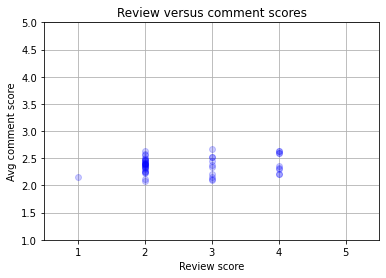

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

gpu_sentiments = [[],[]]

# {gpu : (rev_stars, rev_conf, avg_cmt_stars, [cmt_results]) }
for gpu in GPU_results.keys():
    gpu_rating = GPU_results[gpu][0]
    cmt_rating = GPU_results[gpu][2]
    gpu_sentiments[0].append(gpu_rating)
    gpu_sentiments[1].append(cmt_rating)

gpu_sentiments_t = [list(i) for i in zip(*gpu_sentiments)]
print(gpu_sentiments_t)

sentiments_np = np.array(gpu_sentiments_t)

#print(gpu_sentiments)

plt.plot(gpu_sentiments[0], gpu_sentiments[1], 'bo', alpha=0.2)
plt.axis([0.5, 5.5, 1, 5])
plt.grid()
plt.title("Review versus comment scores")
plt.xlabel("Review score")
plt.ylabel("Avg comment score")
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(gpu_sentiments_t, columns=['Review score', 'Average comment score'])
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6.5))
ax = sns.stripplot(x="Review score", y="Average comment score", data=df, color='b')

[]

<Figure size 648x288 with 0 Axes>

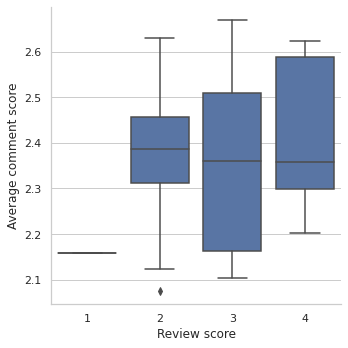

In [21]:
plt.figure(figsize=(9, 4))
ax = sns.catplot(data=df, x="Review score", y="Average comment score", kind="box", color='b')
plt.plot()

In [ ]:
# calculate Pearson's correlation
corr, pval = pearsonr(gpu_sentiments[0], gpu_sentiments[1])
print('Pearsons correlation: %.3f' % corr)
print('P-value: %.4f' % pval)

# Manual comment sentiment validation

In [52]:
comments = []

In [63]:
import random
for i in range(1):
    gpu = random.choice(list(GPU_results.keys()))
    cmt = random.choice(GPU_results[gpu][3])
    cmt_len = len(cmt[0])
    #print(f'Comments: {len(comments)}\nPrev.: {comments[-1][2]}/{comments[-1][1]} manual/bert')
    for line in range(cmt_len//65 + 1):
        part = cmt[0][ 65*line : 65*(line +1) ]
        print(part)
    manual_score = int(input('Score (1-5): '))
    clear_output()
    comments.append((cmt[0], cmt[1], manual_score))

In [64]:
for cmt in comments: # bert[1] / manual[2]
    print(cmt[2] - cmt[1])

40


In [70]:
difference_counts = {}
for cmt in comments: # bert[1] / manual[2]
    diff = int(cmt[2]) - cmt[1]
    if diff in difference_counts:
        difference_counts[diff] += 1
    else: difference_counts[diff] = 1
difference_counts

{2: 5, 1: 9, 0: 16, -1: 10}